In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import sys
import os
from astropy import units as u
from astropy.coordinates import SkyCoord,match_coordinates_sky
from astroquery.gaia import Gaia
from astropy.coordinates import Angle
from astropy.table import Table
from astroquery.vizier import Vizier

Duplicate key in file PosixPath('/Users/baotong/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 768 (' font.family: sans-serif')
Duplicate key in file PosixPath('/Users/baotong/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 769 (' font.sans-serif: Arial Unicode MS, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')
Duplicate key in file PosixPath('/Users/baotong/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 770 (' axes.unicode_minus: False')


In [3]:
from matches_info import output_xmmmatchesinfo

In [4]:
(matches,xmmmatchinfolist)=output_xmmmatchesinfo()

In [5]:
ra_e=matches['RA'];dec_e=matches['DEC']
coord_e = SkyCoord(ra_e*u.degree, dec_e*u.degree)

In [ ]:
maxrad = 0.005* u.degree
outputheader=['eID','ra_e','dec_e','mean_xmmra','mean_xmmdec','number of xmm positions',
              'ra_gaia','dec_gaia','sep_gaia2xmm','Plx','e_Plx','PM','e_pmRA','e_pmDE',
              'Gmag','BPmag','RPmag']
output_file = 'xmm2gaia.csv'

# 逐行写入数据
with open(output_file, mode='w', newline='') as file:
    file.write(','.join(outputheader) + '\n')  # 将列名写入文件
    for i in range(len(xmmmatchinfolist)):
        xmmra=np.array(xmmmatchinfolist[i][2])[:,0];xmmdec=np.array(xmmmatchinfolist[i][2])[:,1]
        coords = SkyCoord(ra=xmmra * u.deg, dec=xmmdec * u.deg)
        mean_coord = SkyCoord(np.mean(xmmra) * u.deg, np.mean(xmmdec) * u.deg)
        distances = coords.separation(mean_coord).arcsec
        if distances.max()<3:
            print(f'good matches for e-source{i}')
            coord_xmm=SkyCoord(np.array([np.mean(xmmra)]) * u.deg, np.array([np.mean(xmmdec)]) * u.deg)
            result = Vizier(row_limit = -1,columns=['*','Date']).query_region(coord_xmm, radius=maxrad, catalog="I/355")
            gaia_table = result[0]
            coord_gaia = SkyCoord(gaia_table['RAJ2000'],gaia_table['DEJ2000'])
            distance_limit=3.0*u.arcsec
            idxc, idxcatalog, d2d, d3d = coord_gaia.search_around_sky(coord_xmm, distance_limit)
            print(idxcatalog,d2d.arcsec)
            if len(d2d)==1:
                idxcatalog=idxcatalog[0]
                # print(gaia_table[idxcatalog]['Plx'])
                usefulinfo=np.array([gaia_table[idxcatalog]['RAJ2000'],gaia_table[idxcatalog]['DEJ2000'],d2d[0].arcsec,
                                    gaia_table[idxcatalog]['Plx'],gaia_table[idxcatalog]['e_Plx'],gaia_table[idxcatalog]['PM'],
                                    gaia_table[idxcatalog]['e_pmRA'],gaia_table[idxcatalog]['e_pmDE'],gaia_table[idxcatalog]['Gmag'],
                                    gaia_table[idxcatalog]['BPmag'],gaia_table[idxcatalog]['RPmag']])
                outputinfo=np.concatenate((np.array([int(i),ra_e[i],dec_e[i],np.mean(xmmra),np.mean(xmmdec),len(xmmra)]),
                                        usefulinfo))
                file.write(','.join(map(str, outputinfo)) + '\n')

In [6]:
xmm2gaiainfo=pd.read_csv('xmm2gaia.csv')
eID=xmm2gaiainfo['eID']
# print(np.where(xmm2gaiainfo['Plx']>0))

In [7]:
Plx=xmm2gaiainfo['Plx']
Plx=np.nan_to_num(Plx, nan=0)
index_gooddist=np.where(Plx>0)[0]
print(index_gooddist)
Plx=Plx[index_gooddist]
print('137 of 145 xmm2eRASS sources are good (pos_err< 3 arcsec)')
print(f'{len(xmm2gaiainfo)} of 137 sources have good Gaia counterpart (single Gaia match<3 arcsec)')
print(f'{len(Plx)} of {len(xmm2gaiainfo)} Gaia sources have good measurements of parallax')


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  20  21  22  23  24  25  26  27  28  29  30  32  33  34  35  36  37  38
  39  40  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  72  73  74  75  76  77
  78  79  80  81  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100]
137 of 145 xmm2eRASS sources are good (pos_err< 3 arcsec)
101 of 137 sources have good Gaia counterpart (single Gaia match<3 arcsec)
93 of 101 Gaia sources have good measurements of parallax


137 of 145 xmm2eRASS sources are good (pos_err< 3 arcsec)

101 of 137 sources have good Gaia counterpart (single Gaia match<3 arcsec)

93 of 101 Gaia sources have good measurements of parallax

In [8]:

xmm2gaiainfo=xmm2gaiainfo.iloc[index_gooddist]


In [16]:
PM=xmm2gaiainfo['PM']
# PM=np.nan_to_num(PM, nan=0)
e_pmRA=xmm2gaiainfo['e_pmRA']
e_pmDE=xmm2gaiainfo['e_pmDE']
# e_pmRA=e_pmRA[np.where(PM>0)]
# e_pmDE=e_pmDE[np.where(PM>0)];
# PM=PM[np.where(PM>0)]
PM_SNR=PM/np.sqrt(e_pmRA**2+e_pmDE**2)
print(np.sort(PM_SNR))
print('all checked')
distpc=1./(Plx/1000)

[   7.04052814    7.47296369    8.36186246   14.55450344   15.56319887
   17.76401325   20.7040349    23.54822445   27.05983221   30.05300504
   30.67643133   33.14529227   36.02789431   47.03720151   54.39687967
   63.67752385   65.77159468   70.17142753   71.27905669   73.19521265
   75.74446125   79.29289597   81.36089732   83.40378503   84.94137209
   85.71196842   87.41860912   91.06839948   96.98719385  103.87396404
  104.11945862  112.09826251  112.69449738  114.03708389  137.48513256
  138.33088154  152.68675294  182.86346521  183.0897699   196.0808068
  196.81198788  204.55709835  210.00761761  221.81243036  222.14249025
  224.71168125  225.18200546  234.60736522  236.28692691  237.66413217
  256.46880968  257.17986845  264.84999112  275.17091873  277.91323343
  303.28234051  367.4968541   372.00836053  381.19924817  420.62672768
  469.09412564  522.71676618  551.79352768  571.75238191  578.26551514
  590.4800132   624.35127903  762.62467639  824.36614863  905.08442181
  908.3

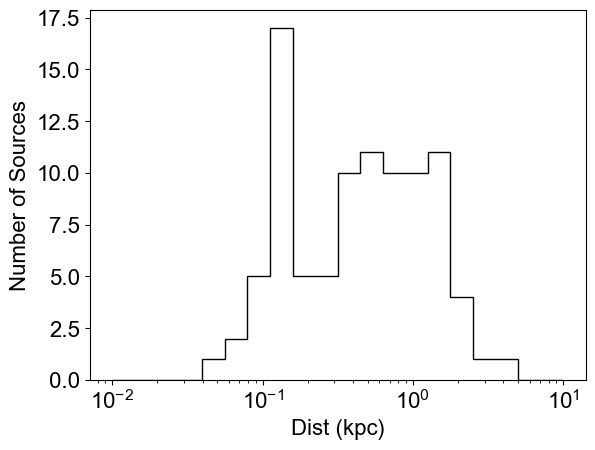

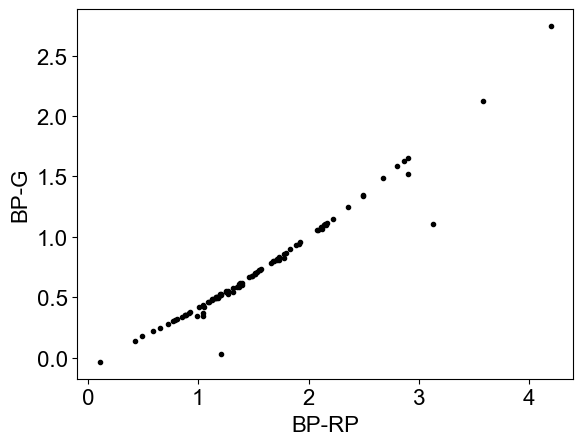

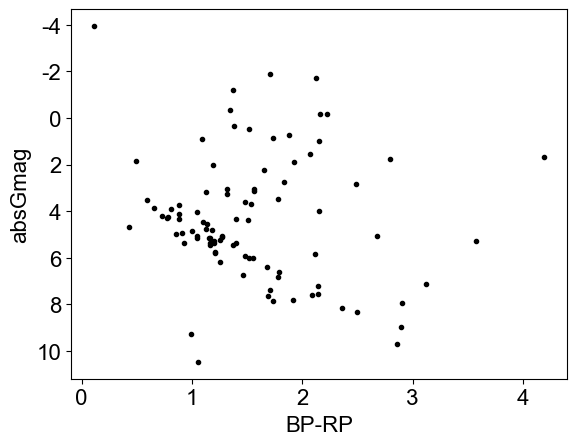

In [17]:
plt.figure(1)
# print(np.sort(1./(Plx/1000)))
plt.hist(distpc/1000,bins=np.logspace(-2,1,21),histtype='step',color='k')
plt.semilogx()
plt.xlabel('Dist (kpc)',fontsize=16)
plt.ylabel('Number of Sources',fontsize=16)
plt.tick_params(labelsize=16)
plt.show()
plt.figure(2)
plt.scatter(xmm2gaiainfo['BPmag']-xmm2gaiainfo['RPmag'],xmm2gaiainfo['BPmag']-xmm2gaiainfo['Gmag'],marker='.',color='k')
plt.xlabel('BP-RP',fontsize=16)
plt.ylabel('BP-G',fontsize=16)
plt.tick_params(labelsize=16)
plt.show()
plt.figure(3)
abs_Gmag = xmm2gaiainfo['Gmag'] - 5 * (np.log10(distpc) - 1)
plt.scatter(xmm2gaiainfo['BPmag']-xmm2gaiainfo['RPmag'],abs_Gmag,marker='.',color='k')
plt.xlabel('BP-RP',fontsize=16)
plt.ylabel('absGmag',fontsize=16)
plt.gca().invert_yaxis()
plt.tick_params(labelsize=16)
plt.show()

[2.80029016e-12 1.01783264e-10 1.09194724e-11 1.02135384e-11
 2.27937609e-11 1.35248037e-12 1.81883219e-12 1.92536556e-12
 2.21767179e-12 1.02007580e-12 4.91536553e-13 3.30192010e-13
 7.45881149e-13 4.89963551e-13 1.86149585e-13 2.19421391e-13
 1.97685753e-13 1.95548430e-13 1.53165417e-13 1.68501470e-13
 1.53029255e-13 1.38606195e-13 7.63109756e-13 1.34317674e-13
 2.33259793e-13 8.59939087e-14 1.03831290e-13 4.53400506e-13
 3.92677095e-13 2.97767767e-13 7.75504064e-14 7.61993279e-14
 2.14859065e-13 7.38277645e-13 8.25979638e-14 5.94797107e-14
 9.86678541e-14 8.80486276e-14 5.87668748e-14 8.45885726e-14
 7.67659184e-14 1.00309634e-13 4.90828407e-13 2.03262822e-13
 1.35751788e-13 3.02093421e-13 5.85422959e-14 6.92671831e-14
 7.04019769e-14 7.16521623e-13 6.03781131e-13 2.85458490e-13
 1.68081450e-13 1.47408290e-13 1.67330857e-13 1.50369775e-13
 1.17289940e-13 1.18090880e-13 1.45083435e-13 7.99742827e-14
 7.21460313e-14 2.01162168e-13 9.31347488e-14 5.67285646e-14
 6.52500112e-14 7.439333

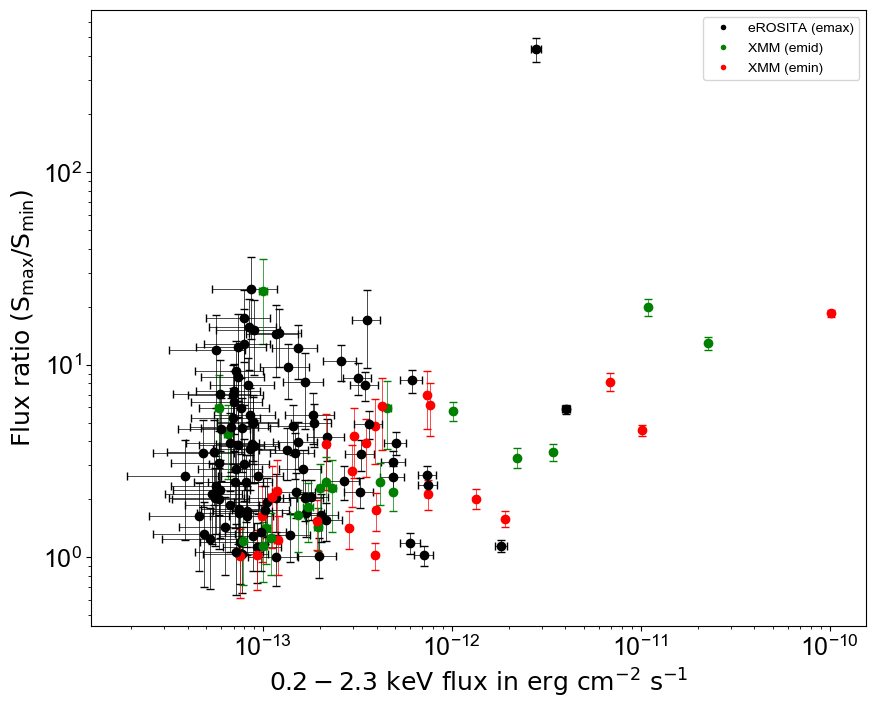

In [18]:
import astropy.units as u
import astropy.constants as c
from matches_info import plot_fluxratio
msun=-26.7 
absmsun=4.66
Lsun=3.846e33*(u.erg/u.s)  ## all in G band
Fopt=10**(0.4*(msun-Gmag))*Lsun/(4*np.pi*(1*u.au)**2)
Fopt=Fopt.to(u.erg/u.cm**2/u.s).value

eflux=matches[index_gooddist]['ML_FLUX_1']
efluxerr=matches[index_gooddist]['ML_FLUX_ERR_1']
maxS=plot_fluxratio(matches,xmmmatchinfolist)
print(maxS)

In [19]:
Fx=maxS[index_gooddist]   #max of xmm and esass flux

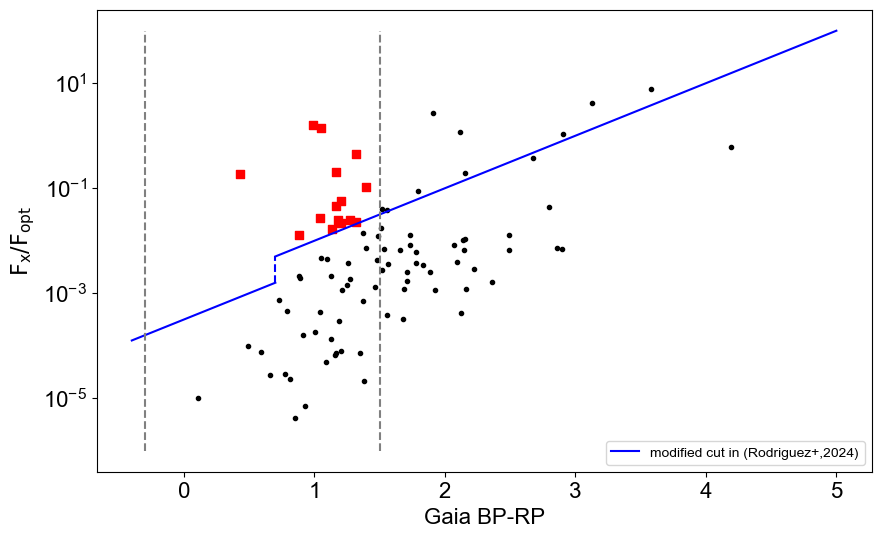

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(xmm2gaiainfo['BPmag']-xmm2gaiainfo['RPmag'],Fx/Fopt,marker='.',color='black')
x1 = np.linspace(-0.4, 0.7, 50)
y1 = 10 ** (x1 - 3.5)
x2 = np.linspace(0.7,5,50)
y2 = 10 ** (x2- 3)
plt.plot(x1, y1,'-', color='blue')
plt.plot(x2, y2, label='modified cut in (Rodriguez+,2024)', color='blue')
plt.plot([0.7,0.7],[y1[-1],y2[0]],'--',color='blue')
plt.plot([1.5,1.5],[1e-6,1e2],'--',color='gray')
plt.plot([-0.3,-0.3],[1e-6,1e2],'--',color='gray')
plt.semilogy()
x=xmm2gaiainfo['BPmag']-xmm2gaiainfo['RPmag']
logy=np.log10(Fx/Fopt)
index_compact=np.where((logy>x-3)&(x<1.5))[0]
plt.scatter(x.iloc[index_compact],10**logy[index_compact],marker='s',color='red',s=30)

plt.xlabel('Gaia BP-RP',fontsize=16)
plt.ylabel(r'$\rm F_x/F_{\rm opt}$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend()
plt.semilogy()
plt.show()


In [33]:
print(index_gooddist)
print(index_gooddist[index_compact])

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  20  21  22  23  24  25  26  27  28  29  30  32  33  34  35  36  37  38
  39  40  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  72  73  74  75  76  77
  78  79  80  81  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100]
[ 1  2  4 12 20 23 24 77 78 79 80 84 85 92 99]


[ 0  1  3 11 18 21 22 71 72 73 74 76 77 84 91]


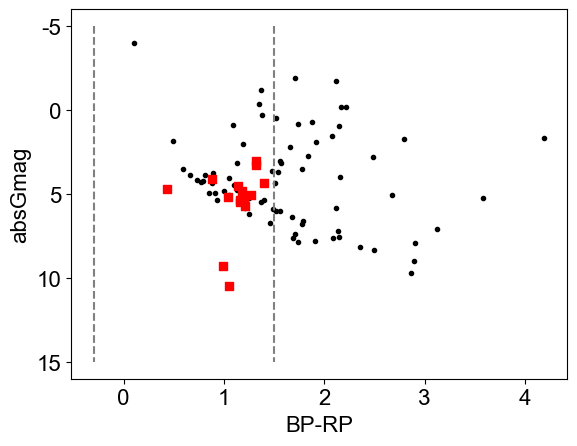

In [35]:
plt.figure(3)
print(index_compact)
plt.scatter(xmm2gaiainfo['BPmag']-xmm2gaiainfo['RPmag'],abs_Gmag,marker='.',color='k')
plt.scatter(xmm2gaiainfo.iloc[index_compact]['BPmag']-xmm2gaiainfo.iloc[index_compact]['RPmag'],abs_Gmag.iloc[index_compact],marker='s',color='red',s=30)
plt.plot([1.5,1.5],[-5,15],'--',color='gray')
plt.plot([-0.3,-0.3],[-5,15],'--',color='gray')
plt.xlabel('BP-RP',fontsize=16)
plt.ylabel('absGmag',fontsize=16)
plt.gca().invert_yaxis()
plt.tick_params(labelsize=16)
plt.show()

Out of curiosity, what is the usual population of Gaia sources in BP-RP vs absG plot？

In [36]:
coord_test1=coord_e[0]
maxrad=0.1*u.degree
result = Vizier(row_limit = -1,columns=['*','Date']).query_region(coord_test1, radius=maxrad, catalog="I/355")
gaia_table = result[0]

In [ ]:
plt.figure(3)
print(index_compact)
plt.scatter(xmm2gaiainfo['BPmag']-xmm2gaiainfo['RPmag'],abs_Gmag,marker='.',color='k')
plt.scatter(xmm2gaiainfo.iloc[index_compact]['BPmag']-xmm2gaiainfo.iloc[index_compact]['RPmag'],abs_Gmag[index_compact],marker='s',color='red',s=30)

plt.scatter(gaia_table['BPmag']-gaia_table['RPmag'],gaia_table['Gmag'] - 5 * (np.log10(1/(gaia_table['Plx']/1000)) - 1),marker='.',color='gray')
plt.plot([1.5,1.5],[-5,15],'--',color='gray')
plt.plot([-0.3,-0.3],[-5,15],'--',color='gray')
plt.xlabel('BP-RP',fontsize=16)
plt.ylabel('absGmag',fontsize=16)
plt.xlim(0,2)
plt.gca().invert_yaxis()
plt.tick_params(labelsize=16)
plt.show()

In [57]:
## choose the targeted cluster source first
path='/Users/baotong/data_GalDisc/data/mosaic_latest/'
xmmsrclist=pd.read_csv(path+'allxmmsrclist.csv')
coord_cluster=SkyCoord(ra=260.0599421*u.degree,dec=-35.9440718*u.degree)
coord_xmm=SkyCoord(ra=np.array(xmmsrclist['ra'])*u.degree,dec=np.array(xmmsrclist['dec'])*u.degree)
sep=coord_xmm.separation(coord_cluster).arcmin
idcluster=np.where(sep<8.)[0]
coord_xmmcluster=coord_xmm[idcluster]
# xmmsrclist['obsid'].iloc[idcluster]
xmmcluster_srcinfo=xmmsrclist.iloc[idcluster]
print(len(idcluster))

93


In [64]:
outputheader=['xmmra','xmmdec','xmmobsid','xmmsrcid','ra_gaia','dec_gaia','sep_gaia2xmm','Plx','e_Plx','PM','e_pmRA','e_pmDE',
              'Gmag','BPmag','RPmag']
output_file = 'cluster2gaia.csv'
result = Vizier(row_limit = -1,columns=['*','Date']).query_region(coord_cluster, radius=10*u.arcmin, catalog="I/355")
gaia_table = result[0]

In [65]:
with open(path+output_file, mode='w', newline='') as file:
    file.write(','.join(outputheader) + '\n')  # 将列名写入文件
    for i in range(len(idcluster)):
        coordtmp=coord_xmmcluster[i]
        coord_gaia = SkyCoord(gaia_table['RAJ2000'],gaia_table['DEJ2000'])
        distance_limit=3.0*u.arcsec
        indexgaia=np.where(coord_gaia.separation(coordtmp)<distance_limit)[0]
        # idxc, idxcatalog, d2d, d3d = coord_gaia.search_around_sky(coordtmp, distance_limit)
        if len(indexgaia)==1:
            print(i)
            indexgaia=indexgaia[0]
            usefulinfo=np.array([gaia_table[indexgaia]['RAJ2000'],gaia_table[indexgaia]['DEJ2000'],
                                 coord_gaia[indexgaia].separation(coordtmp).arcsec,
                                gaia_table[indexgaia]['Plx'],gaia_table[indexgaia]['e_Plx'],gaia_table[indexgaia]['PM'],
                                gaia_table[indexgaia]['e_pmRA'],gaia_table[indexgaia]['e_pmDE'],gaia_table[indexgaia]['Gmag'],
                                gaia_table[indexgaia]['BPmag'],gaia_table[indexgaia]['RPmag']])
            outputinfo=np.concatenate((np.array(xmmcluster_srcinfo.iloc[i]),usefulinfo))
            file.write(','.join(map(str, outputinfo)) + '\n')

0
1
3
4
11
15
16
18
20
24
26
28
29
30
31
32
34


/var/folders/z1/8lm05_ks6676c0ppy4pxnrlm0000gn/T/ipykernel_34198/704731194.py:12: UserWarning: Warning: converting a masked element to nan.
  usefulinfo=np.array([gaia_table[indexgaia]['RAJ2000'],gaia_table[indexgaia]['DEJ2000'],


38
40
46
48
49
50
51
53
54
55
56
60
63
66
70
71
74
75
77
79
80
82
83
85
86
88
89


In [66]:
clustergaia=pd.read_csv(path+'cluster2gaia.csv')

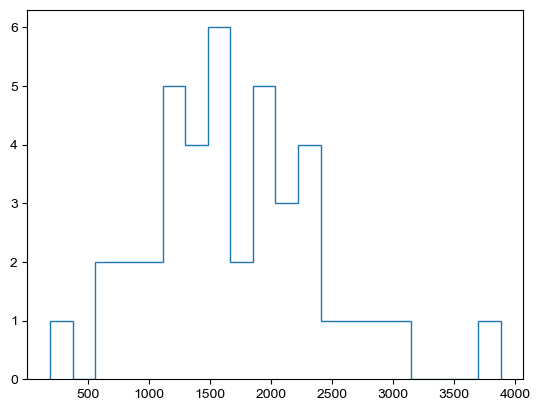

In [69]:
plt.hist(1000/clustergaia['Plx'],bins=20,histtype='step')
plt.show()

In [105]:
MWclusterlist=pd.read_csv(path+'gaia_cluster.csv',sep=';')
print(path)
MWclusterlist=MWclusterlist[2:]
# print(np.array(MWclusterlist['Glon'].iloc[1]))
Glon=np.array(MWclusterlist['Glon']).astype('float64')
Glat=np.array(MWclusterlist['Glat']).astype('float64')

/Users/baotong/data_GalDisc/data/mosaic_latest/


In [112]:
catalog_cluster=SkyCoord(l=Glon*u.degree,
                         b=Glat*u.degree,frame='galactic')
print(np.sort(catalog_cluster.separation(coord_cluster).arcmin))
indices = np.argsort(catalog_cluster.separation(coord_cluster).arcmin)[:10]
print(catalog_cluster[indices])

[9.96721628e+00 3.22794919e+01 4.31286110e+01 ... 1.07494667e+04
 1.07570122e+04 1.07616851e+04]
<SkyCoord (Galactic): (l, b) in deg
    [(351.04410483,  0.65335118), (350.93037464,  0.20213354),
     (351.20660551,  1.38053964), (350.53094391,  0.30032288),
     (350.42790259,  1.0224094 ), (350.11455844,  1.11820135),
     (351.40571972, -0.5412114 ), (350.54295295,  1.68212848),
     (350.98927238, -0.5981989 ), (350.79325832, -0.68681673)]>
